# Measure Simple Statistics of Precision Loss
What's the average error of our measurements? How does that effect easily-derivable quantities, like the integral of charge over cycle? 

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np

Configuration

In [2]:
reference = Path('reduced-datasets/fulltime-float64.pkl')

## Make a Utility Function
Make a function that iterates over the datasets at reduced precisions

In [3]:
full_prec = pd.read_pickle(reference)

In [4]:
full_prec.head()

,Datetime,Current_A,Voltage_V,Cell_Temperature_C
0,2021-01-03 10:37:00.999980,0.0,3.276036,29.7005
1,2021-01-03 10:37:00.999980,0.0,3.271916,29.7005
2,2021-01-03 10:37:04.999958,0.0,3.272068,29.7005
3,2021-01-03 10:37:04.999958,0.0,3.271458,29.7005
4,2021-01-03 10:37:12.000000,0.0,3.271916,29.7166


In [5]:
def iterate_over_low_precision():
    """Yield tuples of (precision level, resampled data)"""

    for path in Path('reduced-datasets/').glob('fulltime-*pkl'):
        if path.name != reference.name:
            level = path.name[9:-4]
            yield level, pd.read_pickle(path)

In [6]:
next(iterate_over_low_precision())

('float32',
                         Datetime  Current_A  Voltage_V  Cell_Temperature_C
 0     2021-01-03 10:37:00.999980        0.0   3.276036             29.7005
 1     2021-01-03 10:37:00.999980        0.0   3.271916             29.7005
 2     2021-01-03 10:37:04.999958        0.0   3.272068             29.7005
 3     2021-01-03 10:37:04.999958        0.0   3.271458             29.7005
 4     2021-01-03 10:37:12.000000        0.0   3.271916             29.7166
 ...                          ...        ...        ...                 ...
 74499 2021-03-09 09:00:05.999957        0.0   3.646982             29.9259
 74500 2021-03-09 09:10:06.000012        0.0   3.646372             29.7166
 74501 2021-03-09 09:20:05.999966        0.0   3.645762             29.9098
 74502 2021-03-09 09:29:05.999974        0.0   3.645151             29.8293
 74503 2021-03-09 09:29:06.999969        0.0   3.644999             29.8293
 
 [74270 rows x 4 columns])

## Compare the Error Between Each Value
Determine statistics about the distribution of differences values after each level of fidelity decrease

In [7]:
error_comparision = []
for level, low_prec in iterate_over_low_precision():
    record = dict(level=level)
    for c in full_prec.columns[1:]:
        err = full_prec[c] - low_prec[c]
        record[f'{c}-mean'] = err.mean()
        record[f'{c}-mae'] = err.abs().mean()
        record[f'{c}-rmse'] = np.sqrt(err.pow(2).mean())
        record[f'{c}-max'] = np.sqrt(err.pow(2).mean())
    error_comparision.append(record)

In [8]:
error_comparision = pd.DataFrame(error_comparision).sort_values('Voltage_V-rmse')
error_comparision

,level,Current_A-mean,Current_A-mae,Current_A-rmse,Current_A-max,Voltage_V-mean,Voltage_V-mae,Voltage_V-rmse,Voltage_V-max,Cell_Temperature_C-mean,Cell_Temperature_C-mae,Cell_Temperature_C-rmse,Cell_Temperature_C-max
2,uint32,-7.127941e-12,1.435920e-11,1.616879e-11,1.616879e-11,-7.277175e-13,7.554413e-11,8.729317e-11,8.729317e-11,2.416290e-12,4.043128e-11,4.662752e-11,4.662752e-11
0,float32,-6.660918e-11,2.198506e-10,3.005741e-10,3.005741e-10,4.355685e-10,7.334089e-08,8.985429e-08,8.985429e-08,2.164828e-07,3.359238e-07,4.016789e-07,4.016789e-07
4,uint16,-1.348519e-07,8.925536e-07,1.055247e-06,1.055247e-06,2.272336e-08,4.917021e-06,5.696538e-06,5.696538e-06,9.024303e-08,2.715589e-06,3.123914e-06,3.123914e-06
3,float16,7.300372e-08,1.448100e-06,2.337332e-06,2.337332e-06,-1.427107e-05,5.833611e-04,7.111220e-04,7.111220e-04,2.840714e-03,3.139402e-03,3.688078e-03,3.688078e-03
1,uint8,1.099163e-04,3.114418e-04,3.153037e-04,3.153037e-04,2.353612e-06,1.275257e-03,1.471335e-03,1.471335e-03,-3.699776e-06,7.003408e-04,8.019913e-04,8.019913e-04


Make a boxplot for errors in 

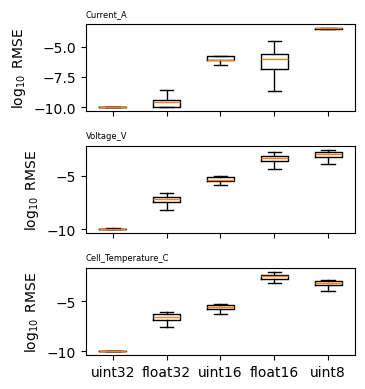

In [9]:
fig, axs = plt.subplots(3, 1, figsize=(3.75, 4.), sharex=True)

for ax, col in zip(axs, full_prec.columns[1:]):

    # Gather the errors for that column
    box_data = []
    for lev in error_comparision['level']:
        low_prec = pd.read_pickle(reference.parent / f'fulltime-{lev}.pkl')
        err = np.log10(np.clip((full_prec[col] - low_prec[col]).abs(), 1e-10, None))
        box_data.append(err)

    ax.boxplot(box_data, showfliers=False)
    ax.set_title(col, fontsize=6, loc='left')

    ax.set_ylabel('$\log_{10}$ RMSE')

axs[-1].set_xticks(np.arange(len(error_comparision['level'])) + 1)
axs[-1].set_xticklabels(error_comparision['level'])
fig.tight_layout()

Short answer: go for uint16 if we want maximum errors of ~1e-6.